# ----------------------------------------------0.导入包--------------------------------------------------

In [45]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.utils.data.sampler import RandomSampler

# ----------------------------------------------1.超参数集合-------------------------------------------
- 用到什么超参数就往这里加

In [136]:
train_image_dir = 'data/train/images'
train_mask_dir = 'data/train/masks'
test_image_dir = 'data/test/images'

lr = 0.001
weight_decay = 0.0001
epochs = 3
batch_size = 12

pad_left = 27
pad_right = 27
fine_size = 202


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------------------------2.准备数据集--------------------------------------------

- 数据集使用Kaggle盐体分割比赛https://link.zhihu.com/?target=https%3A//www.kaggle.com/c/tgs-salt-identification-challenge
- 典型的图象分割数据集

- 数据集包含输入图像和mask图像：
    - 输入图像：是原始采集的图像，正常像素值
    - mask图像：与原图像大小一样，但每个像素的数字表示类别，是一个像素级的标签
- 数据增广：图像的获取和标注是昂贵的，因此应用数据增广非常有必要

- 准备好的数据集是什么样子的（也就是模型的输入）：
    - 是一个经过处理的图像，图像的大小可能已经因为数据增广和特征工程改变了，但没关系
    - 标签，也就是mask图像

In [5]:
"""数据预处理和特征工程"""

# 首先处理数据集中的深度数据，将深度数据作为一个特征添加到图像中
depths = pd.read_csv('data/depths.csv') # 打开深度数据文件，里面包含每个图片的名称和对应的深度数字
depths.sort_values('z', inplace=True) # 根据深度数字对表进行原地排序，也就是不返回一个副本
depths.drop('z', axis=1, inplace=True) # 删除深度数据
depths['fold'] = (list(range(0, 5)) * depths.shape[0])[:depths.shape[0]] # 添加新的fold列，以循环的0-4数字填充，这里是方便数据进行5折交叉验证


# 打开训练的集的标注文件
train_df = pd.read_csv('data/train.csv') # 打开训练集标注文件
train_df = train_df.merge(depths) # 将处理后的深度文件添加到标注文件中,.merge会根据同一个文件名自动添加

# 添加一个新的特征：每张图像为唯一像素值数量
dist = []
for id in train_df.id.values: # 获取图片的名称
    img = cv2.imread(f'data/train/images/{id}.png', cv2.IMREAD_GRAYSCALE) # 以灰度图像的形式打开图片，灰度（一个代表黑白程度的值）
    dist.append(np.unique(img).shape[0]) # 计算每张图像中唯一像素值的数量，将其作为图片的一个新的特征
train_df['unique_pixels'] = dist

In [6]:
"""添加两个特征维度后的标注数据"""
train_df.head()

,id,rle_mask,fold,unique_pixels
0,2c45b152f1,99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...,4,188
1,3cb59a4fdc,1 5656,1,224
2,e185ab5dc1,4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...,3,207
3,c78c89577c,101 1,4,183
4,6306dd3a8e,1 30 102 29 203 29 304 28 405 27 506 27 607 26...,4,224


In [26]:
"""读取训练图像和掩码图像，处理成np格式备用"""
def trainImageFetch(images_id):
    image_train =  np.zeros((images_id.shape[0], 101, 101), dtype=np.float32) # 创建一个和输入图片大小与总数量一样的全零np数组
    mask_train = np.zeros((images_id.shape[0], 101, 101), dtype=np.float32)
    
    for idx, image_id in tqdm(enumerate(images_id), total=images_id.shape[0]):
        image_path = os.path.join(train_image_dir, image_id+'.png') # 图片路径
        mask_path = os.path.join(train_mask_dir, image_id+'.png') # 掩码路径
        
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255 # 灰度打开图像，除以255将像素值归一到0-1范围
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255 # 以灰度打开图像
        
        image_train[idx] = image  # 将处理好的像素数据按照索引添加到空的np数组中
        mask_train[idx] = mask
    
    return image_train, mask_train
# 返回的是np格式的图像和掩码图像数据  

In [8]:
"""读取测试集图像"""
def testImageFetch(test_id):
    image_test = np.zeros((len(test_id), 101, 101), dtype=np.float32) # 创建一个和test数据集一样的小的空np数组
    
    for idx, image_id in tqdm(enumerate(test_id), total=len(test_id)):
        image_path = os.path.join(test_image_dir, image_id+'.png')
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255 # 以灰度模式打开图像
        image_test[idx] = image # 添加到np数组中
        
    return image_test
# 返回处理好的测试集图像

In [9]:
"""定义图片缩放操作"""
def do_resize2(image, mask, H, W):
    image = cv2.resize(image, dsize=(W, H)) # 缩放图片大小
    mask = cv2.resize(mask, dsize=(W, H))
    return image, mask

In [10]:
"""定以图片填充操作"""
def do_center_pad(image, pad_left, pad_right):
    return np.pad(image, (pad_left, pad_right), 'edge') # 使用边缘像素对图片进行填充

In [11]:
"""返回图像和掩码经过填充后的结果"""
def do_center_pad2(image, mask, pad_left, pad_right):
    image = do_center_pad(image, pad_left, pad_right)
    mask = do_center_pad(mask, pad_left, pad_right)
    return image, mask

In [72]:
"""自定义数据集"""
class SaltDataset(Dataset):
    def __init__(self, image_list, mode, mask_list=None, fine_size=202, pad_left=0, pad_right=0): # 提供的默认信息
        self.imagelist = image_list
        self.mode = mode
        self.masklist = mask_list
        self.fine_size = fine_size
        self.pad_left = pad_left
        self.pad_right = pad_right
        
    def __len__(self): # 返回数据集的总长度
        return len(self.imagelist)
        
    def __getitem__(self, idx): # 返回根据索引并经过处理的图像和掩码图像，以及验证的测试的处理图像
        image = deepcopy(self.imagelist[idx]) # 拷贝图像
        
        if self.mode == 'train': # 训练模式下的图像处理操作
            mask = deepcopy(self.masklist[idx])
            label = np.where(mask.sum() == 0, 1.0, 0.0).astype(np.float32) # 生成标签，存在晶体的为1，不存在也就是不需要划分的为0
            
            if self.fine_size != image.shape[0]: # 判断图片是否需要进行缩放
                image, mask = do_resize2(image, mask, self.fine_size, self.fine_size)
            
            if self.pad_left != 0: # 判断图片是否需要进行填充
                image, mask = do_center_pad2(image, mask, self.pad_left, self.pad_right)
            
            image = image.reshape(1, image.shape[0], image.shape[1]) # 添加维度
            mask = mask.reshape(1, mask.shape[0], mask.shape[1])
            
            return image, mask, label
        
        elif self.mode == 'val': # 验证模式下的图片处理操作
            mask = deepcopy(self.masklist[idx])
            
            if self.fine_size != image.shape[0]:
                image, mask = do_resize2(image, mask, self.fine_size, self.fine_size)
            
            if self.pad_left != 0:
                image = do_center_pad(image, self.pad_left, self.pad_right)
            
            image = image.reshape(1, image.shape[0], image.shape[1])
            mask = mask.reshape(1, mask.shape[0], mask.shape[1])
            
            return image, mask
        
        elif self.mode == 'test': # 测试模式下的图片处理操作
            if self.fine_size != image.shape[0]:
                image = cv2.resize(image, dsize=(self.fine_size, self.fine_size))
            
            if self.pad_left != 0:
                image = do_center_pad(image, self.pad_left, self.pad_right)
            
            image = image.reshape(1, image.shape[0], image.shape[1])
            
            return image

In [58]:
"""实例化数据集并打包"""
all_id = train_df['id'].values # 获取全部图片id

# 按照5折来划分数据
fold = []
for i in range(5):
    fold.append(train_df.loc[train_df['fold']==i, 'id'].values) # 返回的fold包含5个numpy数组，也就是5折


# 因为是5折交叉验证，所有准备数据集的过程要在定义训练函数的时候进行
    


# ----------------------------------------------3.定义模型-----------------------------------------------
- 定义U-Net模型
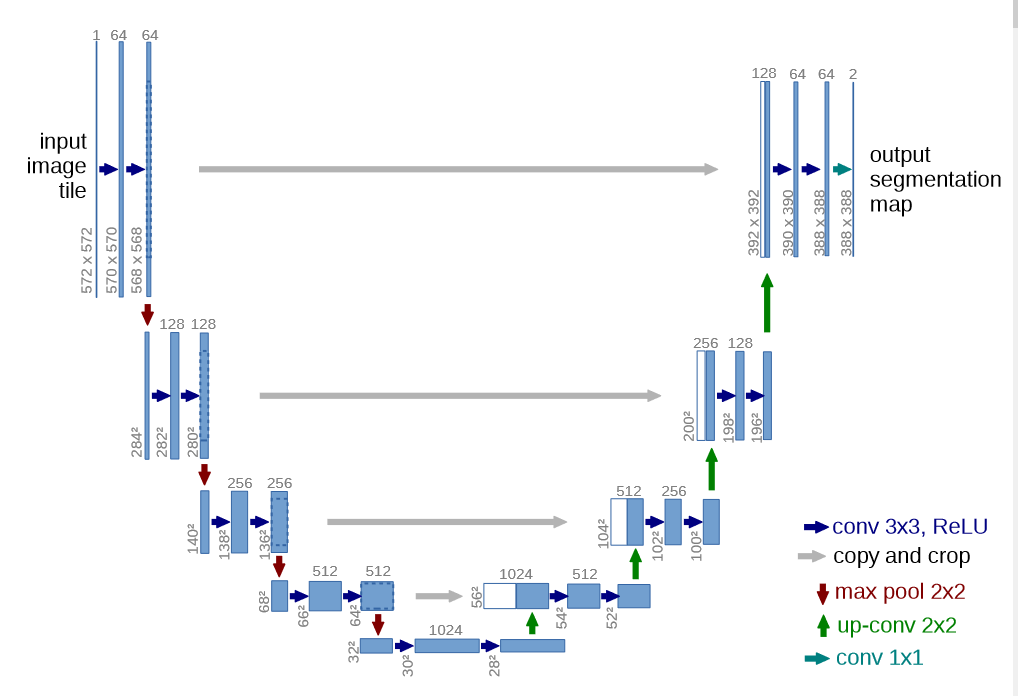

- 关于转置卷积层的操作：
   - 反卷积操作的基本原理是对输入特征图进行上采样，增加特征图的尺寸。它通过将输入的每个像素之间插入一些空白像素来进行上采样。这个操作可以使特征图的尺寸扩大，通常用于恢复或生成更高分辨率的特征图。
    - 填充的具体值对于最终模型的输出可能并不是非常重要，因为通常这些填充值会在之后的网络层中经过激活函数或其他操作而被修改或消除。填充值的目的在于确保卷积和反卷积等操作在特征图的边界处能够正确地进行计算，保持输出尺寸与预期一致。

In [101]:
"""定义上采样和传递信息的操作类"""
class Decoder(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(Decoder, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2) # 转置卷积层，与传统卷积操作相反，填入0像素
        self.conv_relu = nn.Sequential(
                                nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
                                nn.ReLU(inplace=True))
        
    def forward(self, x1, x2):
        x1 = self.up(x1) # 上采样x1
        x1 = torch.cat((x1, x2), dim=1) # 拼接两个矩阵
        x1 = self.conv_relu(x1)
        return x1
        

In [117]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        self.base_layers = list(self.base_model.children())
        self.layer1 = nn.Sequential(
                                    nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
                                    self.base_layers[1],
                                    self.base_layers[2])
        self.layer2 = nn.Sequential(*self.base_layers[3:5])
        self.layer3 = self.base_layers[5]
        self.layer4 = self.base_layers[6]
        self.layer5 = self.base_layers[7]
        self.decode4 = Decoder(512, 256+256, 256)
        self.decode3 = Decoder(256, 256+128, 256)
        self.decode2 = Decoder(256, 128+64, 128)
        self.decode1 = Decoder(128, 64+64, 64)
        self.decode0 = nn.Sequential(
                                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                                    nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=False),
                                    nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False))
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        e1 = self.layer1(input) # 64, 128, 128
        e2 = self.layer2(e1) # 64, 64, 64
        e3 = self.layer3(e2) # 128, 32, 32
        e4 = self.layer4(e3) # 256, 16, 16
        f = self.layer5(e4) # 512, 8, 8
        d4 = self.decode4(f, e4) # 256, 16, 16
        d3 = self.decode3(d4, e3) # 256, 32, 32
        d2 = self.decode2(d3, e2) # 128, 64, 64
        d1 = self.decode1(d2, e1) # 64, 128, 128
        d0 = self.decode0(d1) # 64, 256, 256
        out = self.conv_last(d0) # 1, 256, 256
        return out

In [118]:
"""实例化模型"""
salt = UNet(1)
salt.to(device)

UNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

# ----------------------------------------------4.定义训练函数-----------------------------------------

In [122]:
"""定义训练方法"""
def train(train_loader, model):
    running_loss = 0.0
    data_size = len(train_data)
    # 设置参数优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    model.train() # 进入训练模式
    
    for inputs, masks, labels in train_loader:
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device) # 将数据传入到GPU中
        optimizer.zero_grad() # 清零梯度
        
        # 前向传播
        logit = model(inputs)

        
        # 计算损失和梯度
        loss = nn.BCEWithLogitsLoss()(logit.squeeze(1), masks.squeeze(1))
        loss.backward()
        
        # 更新模型参数
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # 计算每个epoch下的损失
    epoch_loss = running_loss / data_size
    return epoch_loss

In [130]:
"""定义测试函数"""
def do_kaggle_metric(predict,truth, threshold=0.5):

    N = len(predict)
    predict = predict.reshape(N,-1)
    truth   = truth.reshape(N,-1)

    predict = predict>threshold
    truth   = truth>0.5
    intersection = truth & predict
    union        = truth | predict
    iou = intersection.sum(1)/(union.sum(1)+1e-8)

    #-------------------------------------------
    result = []
    precision = []
    is_empty_truth   = (truth.sum(1)==0)
    is_empty_predict = (predict.sum(1)==0)

    threshold = np.array([0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])
    for t in threshold:
        p = iou>=t

        tp  = (~is_empty_truth)  & (~is_empty_predict) & (iou> t)
        fp  = (~is_empty_truth)  & (~is_empty_predict) & (iou<=t)
        fn  = (~is_empty_truth)  & ( is_empty_predict)
        fp_empty = ( is_empty_truth)  & (~is_empty_predict)
        tn_empty = ( is_empty_truth)  & ( is_empty_predict)

        p = (tp + tn_empty) / (tp + tn_empty + fp + fp_empty + fn)

        result.append( np.column_stack((tp,fp,fn,tn_empty,fp_empty)) )
        precision.append(p)

    result = np.array(result).transpose(1,2,0)
    precision = np.column_stack(precision)
    precision = precision.mean(1)

    return precision, result, threshold

In [128]:
"""定义测试方法"""
def test(test_loader, model):
    running_loss = 0.0
    data_size = len(test_loader)
    predicts = []
    truths = []
    
    model.eval() # 进入预测模式
    
    for inputs, masks in test_loader:
        inputs, masks = inputs.to(device), masks.to(device)
        
        outputs = model(inputs)
        outputs = outputs[:, :, pad_left:pad_left + fine_size, pad_left:pad_left +fine_size].contiguous() # 对模型输出进行裁剪
        loss = nn.BCEWithLogitsLoss()(outputs.squeeze(1), masks.squeeze(1))
        
        predicts.append(torch.sigmoid(outputs).detach().cpu().numpy()) # 将预测结果转化为0-1的概率和numpy格式，也就是预测的图像
        truths.append(masks.detach().cpu().numpy()) # 真实的掩码图像
        running_loss += loss.item() * inputs.size(0) # 保存批量损失
        
    predicts = np.concatenate(predicts).squeeze() # 将预测结果连接起来，形成整个测试集的预测结果
    truths = np.concatenate(truths).squeeze()
    precision, _, _ = do_kaggle_metric(predicts, truths, 0.5)# 调用测试函数，返回结果预测结果精度
    precision = precision.mean() # 返回均值
    epoch_loss = running_loss / data_size # 计算epoch损失
    return epoch_loss, precision
    

In [145]:
"""将二值图像（numpy数组）编码为Run-Length编码（RLE）一种简单无损数据压缩方法，特别适合大量连续重复的数据"""
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [132]:
num_snapshot = 0
best_acc = 0
    
for epoch in range(epochs):
    train_loss = train(train_loader, salt) # 调用训练模型，这一步已经训练了
    val_loss, accuracy = test(val_loader, salt) # 调用函数在验证集上验证精度

    # 保存最优模型
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(salt.state_dict(), 'data/model')
        print('saveing model with acc {:.3f}'.format(best_acc))

    print('epoch: {} train_loss: {:.3f} val_loss: {:.3f} val_accuracy: {:.3f}'.format(epoch + 1, train_loss, val_loss, accuracy))

saveing model with acc 0.635
epoch: 1 train_loss: 0.257 val_loss: 2.607 val_accuracy: 0.635


# ----------------------------------------------5.开始训练-----------------------------------------------

In [137]:
for idx in range(5):   # 因为是5折所以这里设定是5
    

    
    # 准备数据集
    train_id = np.setdiff1d(all_id, fold[idx]) # 获取除了当前idx外的所有id
    val_id = fold[idx]
    X_train, y_train = trainImageFetch(train_id) # 处理训练图像和掩码图像
    X_val, y_val = trainImageFetch(val_id) # 处理验证集图像
    train_data = SaltDataset(X_train, 'train', y_train, pad_left=27, pad_right=27) # 实例化自定义的数据集
    val_data = SaltDataset(X_val, 'val', y_val, pad_left=27, pad_right=27)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size) # 打包训练用的数据集
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
    
    best_acc = 0
    
    for epoch in range(epochs):
        train_loss = train(train_loader, salt) # 调用训练模型，这一步已经训练了
        val_loss, accuracy = test(val_loader, salt) # 调用函数在验证集上验证精度
        
        # 保存最优模型
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(salt.state_dict(), 'data/model')
            print('saveing model with acc {:.3f}'.format(best_acc))
        
        print('epoch: {} train_loss: {:.3f} val_loss: {:.3f} val_accuracy: {:.3f}'.format(epoch + 1, train_loss, val_loss, accuracy))
        
    
    
    

100%|██████████████████████████████████████████████████████████████████████████████| 810/810 [00:00<00:00, 2673.27it/s]


saveing model with acc 0.658
epoch: 1 train_loss: 0.235 val_loss: 2.494 val_accuracy: 0.658
saveing model with acc 0.668
epoch: 2 train_loss: 0.226 val_loss: 2.339 val_accuracy: 0.668
epoch: 3 train_loss: 0.211 val_loss: 3.309 val_accuracy: 0.606


100%|██████████████████████████████████████████████████████████████████████████████| 804/804 [00:00<00:00, 2744.02it/s]


saveing model with acc 0.661
epoch: 1 train_loss: 0.212 val_loss: 2.377 val_accuracy: 0.661
saveing model with acc 0.673
epoch: 2 train_loss: 0.213 val_loss: 2.115 val_accuracy: 0.673
saveing model with acc 0.689
epoch: 3 train_loss: 0.205 val_loss: 2.413 val_accuracy: 0.689


100%|██████████████████████████████████████████████████████████████████████████████| 811/811 [00:00<00:00, 2739.04it/s]


saveing model with acc 0.662
epoch: 1 train_loss: 0.201 val_loss: 2.097 val_accuracy: 0.662
saveing model with acc 0.679
epoch: 2 train_loss: 0.189 val_loss: 2.967 val_accuracy: 0.679
saveing model with acc 0.709
epoch: 3 train_loss: 0.188 val_loss: 2.458 val_accuracy: 0.709


100%|██████████████████████████████████████████████████████████████████████████████| 790/790 [00:00<00:00, 2724.14it/s]


saveing model with acc 0.686
epoch: 1 train_loss: 0.191 val_loss: 1.600 val_accuracy: 0.686
epoch: 2 train_loss: 0.191 val_loss: 2.267 val_accuracy: 0.640
epoch: 3 train_loss: 0.191 val_loss: 2.170 val_accuracy: 0.679


100%|██████████████████████████████████████████████████████████████████████████████| 785/785 [00:00<00:00, 2918.21it/s]


saveing model with acc 0.692
epoch: 1 train_loss: 0.173 val_loss: 1.881 val_accuracy: 0.692
epoch: 2 train_loss: 0.168 val_loss: 2.452 val_accuracy: 0.653
epoch: 3 train_loss: 0.166 val_loss: 1.991 val_accuracy: 0.690


# ----------------------------------------------6.测试----------------------------------------------------

In [141]:
"""使用测试集生成预测结果并"""
test_id = [x[:-4] for x in os.listdir(test_image_dir) if x[-4:] == '.png'] # 加载测试集图片id
image_test = testImageFetch(test_id) # 加载测试集图片
overall_pred_101 = np.zeros((len(test_id), 101, 101), dtype=np.float32)

100%|███████████████████████████████████████████████████████████████████████████| 18000/18000 [00:57<00:00, 310.98it/s]


In [143]:
for step in range(1, 6):
    print('predicting Snapshot', step)
    pred_null = []
    
    # 打包数据集
    test_data = SaltDataset(image_test, mode='test', fine_size=fine_size, pad_left=pad_left, pad_right=pad_right)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
    
    # 进行预测
    salt.eval()
    for images in tqdm(test_loader, total=len(test_loader)):
        images = images.to(device)
        pred = salt(images)
        pred = torch.sigmoid(pred).squeeze(1).cpu().detach().numpy()
        pred = pred[:, pad_left:pad_left+fine_size, pad_left:pad_left + fine_size]
        pred_null.append(pred)
    
    idx = 0
    for i in range(len(pred_null)):
        for j in range(batch_size):
            overall_pred_101[idx] += cv2.resize(pred_null[i][j], dsize=(101, 101))
            idx += 1

predicting Snapshot 1


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:28<00:00, 52.65it/s]


predicting Snapshot 2


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:27<00:00, 54.37it/s]


predicting Snapshot 3


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:27<00:00, 54.49it/s]


predicting Snapshot 4


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:27<00:00, 54.20it/s]


predicting Snapshot 5


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:27<00:00, 54.06it/s]



# ----------------------------------------------7.生成提交文件----------------------------------------

In [146]:
submission = pd.DataFrame({'id':test_id, 'rle_mask':list(overall_pred_101)})
submission['rle_mask'] = submission['rle_mask'].map(lambda x: rle_encode(x>5*0.5))
submission.set_index('id', inplace=True)

sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.set_index('id', inplace=True)
submission = submission.reindex(sample_submission.index)
submission.reset_index(inplace=True)
submission.to_csv('submission01.csv', index=False)

In [147]:
# 分数0.73148  最高的分数0.89646